In [16]:
#importing useful packages.
#Numpy will be used for working with vectors and matrices. 
import numpy as np 
#Pandas will be used for reading in data
import pandas as pd
from matplotlib import pyplot as plt
import math
import time
import random

In [17]:
#reading in data
training_data = pd.read_csv('emnist-balanced-train.csv', header = None)
testing_data = pd.read_csv('emnist-balanced-test.csv', header = None)

In [18]:
#each label is encoded, so we also read in the file emnist-balanced-mapping.txt for decoding purposes
mapping = pd.read_table('emnist-balanced-mapping.txt', names = ['label', 'unicode'], header = None, delim_whitespace  = True)

#column 0 represents the labels in the data, and column 1 is the corresponding unicode integer. 
#we can see what character each label represents using the chr() function
char_vec = []
for i in range(len(mapping)):
    a = chr(mapping.loc[i][1])
    char_vec.append(a)
mapping['character'] = char_vec
mapping

,label,unicode,character
0,0,48,0
1,1,49,1
2,2,50,2
3,3,51,3
4,4,52,4
5,5,53,5
6,6,54,6
7,7,55,7
8,8,56,8
9,9,57,9


In [19]:
training_data.head()
#column 0 is the label
#each row represents a different image, with columns 1 to 784 representing the pixel values(between 0 and 255)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#turning data into numpy arrays
training_data = np.array(training_data)
testing_data = np.array(testing_data)


In [21]:
#functions we will need

#ReLU activation and its derivative
def ReLu(x):
    return x*(x>0)
def ReLu_der(x):
    return 1*(x>0)

#softmax activation function
def softmax(x):
    z = x - np.amax(x)
    return np.exp(z)/np.sum(np.exp(z))

#define forward propagation
def forward(W_in, b_in, W_hid, b_hid, x, label):
    
    #layer 1
    Z1 = W_in.dot(x) + b_in #weights and biases
    A1 = ReLu(Z1) #activation
    
    #layer 2
    Z2 = W_hid.dot(A1) + b_hid #weights and biases
    A2 = softmax(Z2) #activation

    return Z1, A1, Z2, A2

#define backward propagation
def back(W_in, b_in, W_hid, b_hid, x, Z1, A1, Z2, A2, label):
    #target value
    target = np.zeros((47,1))
    target[label, 0] = 1
    
    #computing loss derivatives with respect to each hyper parameter
    dB2 = (A2 - target)*(A2 - A2*A2)
    dW2 = dB2.dot(np.transpose(A1))
    dB1 = (W_hid.dot(dB2))*ReLu_der(Z1)
    dW1 = dB1.dot(np.transpose(x))
    return dW1, dB1, dW2, dB2

In [22]:
#example from the report
image_Example = testing_data[71:72, 1:785]
label_image_Example = testing_data[71,0]

label_image_Example

26

In [23]:
#we reshape the vector into a 28 by 28 pixel format for plotting purposes
image_Example = image_Example.reshape((28,28))
#we transpose this new matrix to ensure the image is the right way up
image_Example = np.transpose(image_Example)

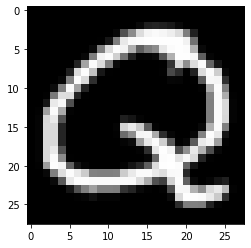

In [24]:
#we plot the image
plt.gray()
plt.imshow(image_Example)
plt.show()

In [25]:
#training section
#this is where we begin the training of the network

#imax is number of images in training set
imax = training_data.shape[0]

#initialising weights and biases
W1 = 0.2*np.random.rand(47, 784) - 0.1
B1 = np.zeros((47,1))
W2 = 0.2*np.random.rand(47, 47) - 0.1
B2 = np.zeros((47,1))

#learning rate
alpha = 0.001

#tic toc computes the time taken by training
tic = time.time()

#initialing vectors to hold training and testing accuracies after each training iteration
accuracy_training_vec = np.zeros((100,1))
accuracy_testing_vec = np.zeros((100,1))

#iterating training over whole training dataset 100 times
for iters in range(100):
    
    #going through all training images and training network
    for i in range(imax):
        vec = training_data[i:i+1, 1:785]
        vec = np.transpose(vec/255)
        label = training_data[i, 0]
        
        #forward propagation
        Z1, A1, Z2, A2 = forward(W1, B1, W2, B2, vec, label)
        
        #back propagation
        dW1, dB1, dW2, dB2 = back(W1, B1, W2, B2, vec, Z1, A1, Z2, A2, label)
        
        #gradient descent
        W1 = W1 - alpha*dW1
        W2 = W2 - alpha*dW2
        B1 = B1 - alpha*dB1
        B2 = B2 - alpha*dB2
        
        
        
        
    #computing testing accuracy after each training iteration and storing in a vector
    accuracy = 0;
    for i in range(len(testing_data)):
        #goes over each testing example
        vec = testing_data[i:i+1, 1:785]
        vec = np.transpose(vec/255)
        #correct label
        label = testing_data[i, 0]

        Z1, A1, Z2, A2 = forward(W1, B1, W2, B2, vec, label)
        prediction = np.argmax(A2) #makes a prediction
        
        #if the prediction matches with the correct label, we add 1 to the accuracy tally
        accuracy = accuracy + (label == prediction) 
        
    #we divide by the number of images, so that now we have a percentage of times the network predicted correctly 
    #and store it in the vector   
    accuracy_testing_vec[iters] = accuracy/len(testing_data) 
    
    
    
    
    #computing training accuracy after each training iteration and storing in a vector
    accuracy = 0;
    for i in range(len(training_data)):
         #goes over each training example
        vec = training_data[i:i+1, 1:785]
        vec = np.transpose(vec/255)
        #correct label
        label = training_data[i, 0]
        
        
        Z1, A1, Z2, A2 = forward(W1, B1, W2, B2, vec, label)
        prediction = np.argmax(A2) #makes a prediction
       
        #if the prediction matches with the correct label, we add 1 to the accuracy tally
        accuracy = accuracy + (label == prediction)
     
    #we divide by the number of images, so that now we have a percentage of times the network predicted correctly
    #and store it in the vector
    accuracy_training_vec[iters] = accuracy/len(training_data)
    
toc = time.time() - tic
#training time in seconds
toc
#end of training section

2712.240706205368

Label: R
Prediction: Z
Prediction confidence: 59.83609835818965


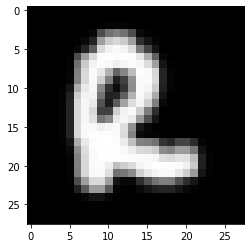

In [37]:
#an example of the network at work, we randomly choose an image from the testing dataset (note:not the one we trained on) 
#to show the network at work
m = len(testing_data)
i = np.random.randint(0,m)
vec = testing_data[i:i+1, 1:785]
vec = np.transpose(vec/255)
label = testing_data[i, 0]
Z1, A1, Z2, A2 = forward(W1, B1, W2, B2, vec, label)
#an example of network prediction (since the image is random the prediction might not be right for a given realisation)
prediction = np.argmax(A2)
print("Label: " + chr(mapping.loc[label][1]))
print("Prediction: " + chr(mapping.loc[prediction][1]))
print("Prediction confidence: " + str(100*A2[prediction,0] ) )

show_image = vec
show_image = show_image.reshape((28,28))
#we transpose this new matrix to ensure the image is the right way up
show_image = np.transpose(show_image)

#we plot the image
plt.gray()
plt.imshow(show_image)
plt.show()

In [52]:
#final accuracy on testing dataset
final_accuracy_testing = round(100*accuracy_testing_vec[-1,0],1)
final_accuracy_training = round(100*accuracy_training_vec[-1,0],1)
print("The final testing accuracy is: " + str(final_accuracy_testing) + "%")
print("The final training accuracy is: " + str(final_accuracy_training) + "%")

The final testing accuracy is: 74.7%
The final training accuracy is: 77.3%


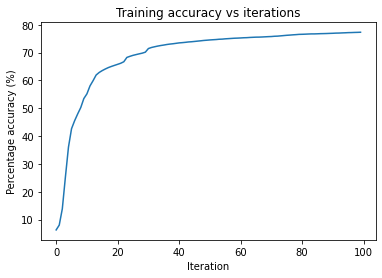

In [53]:
#plotting training accuracy
fig1 = plt.figure()
plt.plot(100*accuracy_training_vec)
plt.xlabel('Iteration')
plt.ylabel('Percentage accuracy (%)')
plt.title('Training accuracy vs iterations')
fig1.savefig('Training_accuracy.jpg')

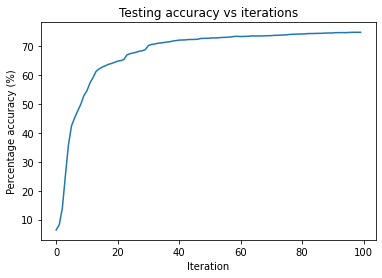

In [54]:
#plotting testing accuracy
fig2 = plt.figure()
plt.plot(100*accuracy_testing_vec)
plt.xlabel('Iteration')
plt.ylabel('Percentage accuracy (%)')
plt.title('Testing accuracy vs iterations')
fig2.savefig('Testing_accuracy.jpg')

In [57]:
#saving final hyper parameters and test results
W1.dump("W1.dat")
W2.dump("W2.dat")
B1.dump("B1.dat")
B2.dump("B2.dat")